In [1]:
import re
import numpy as np
import pandas as pd
import nflreadpy as nfl

In [2]:
import matplotlib.pyplot as plt

In [3]:
seasons = range(2017, 2026)
data = nfl.load_pbp(seasons)

In [4]:
# Carga tus datos (como antes)
seasons = range(2017, 2026)
data = nfl.load_pbp(seasons)

# --- LA SOLUCIÓN ALTERNATIVA ---
# Polars usa .write_csv() y no necesita 'index=False'
data.write_csv('Datos NFL.csv')

print("¡Archivo guardado exitosamente usando Polars!")

¡Archivo guardado exitosamente usando Polars!


In [5]:
data = pd.read_csv("Datos NFL.csv")

C:\Users\gianp\AppData\Local\Temp\ipykernel_34548\1085112198.py:1: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,209,210,213,214,218,219,220,222,224,226,233,234,235,236,237,238,243,244,245,248,249,253,254,255,260,262,263,266,267,268,269,283,284,302,332) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Datos NFL.csv")


In [6]:
print(data.columns)

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'out_of_bounds', 'home_opening_kickoff', 'qb_epa', 'xyac_epa',
       'xyac_mean_yardage', 'xyac_median_yardage', 'xyac_success', 'xyac_fd',
       'xpass', 'pass_oe'],
      dtype='object', length=372)


Podriamos crear varias data sets separando las columnas por el interes o area de juego, aplicar PCA y matriz de covarianza.


In [7]:
 print(data.dtypes.value_counts())

float64    203
object     159
int64       10
Name: count, dtype: int64


In [8]:
data.play_deleted.unique()

array([0., 1.])

In [9]:
GROUP_RULES = {
    # --- 1. Identificadores Únicos ---
    "identificadores": [
        r"^play_id$", r"^game_id$", r"^old_game_id$", r"nfl_api_id", r"nflverse_game_id",
        r"order_sequence"
    ],
    
    # --- 2. Contexto del Partido (Quién, Dónde, Cuándo) ---
    "contexto_partido": [
        r"^season$", r"season_type", r"^week$", r"game_date", r"start_time", r"time_of_day",
        r"stadium", r"stadium_id", r"game_stadium", r"location", r"roof", r"surface",
        r"weather", r"^temp$", r"^wind$", r"div_game", r"home_coach", r"away_coach",
        r"home_team", r"away_team", r"posteam", r"posteam_type", r"defteam",
        r"home_opening_kickoff"
    ],

    # --- 3. Contexto de la Jugada (Situación) ---
    "contexto_jugada": [
        r"play_clock", r"game_half", r"game_seconds_remaining", r"half_seconds_remaining",
        r"quarter_seconds_remaining", r"quarter_end", r"qtr", r"^down$", r"ydstogo",
        r"yrdln", r"yardline_100", r"side_of_field", r"goal_to_go",
        r"home_timeouts_remaining", r"away_timeouts_remaining",
        r"posteam_timeouts_remaining", r"defteam_timeouts_remaining", r"^timeout$", r"timeout_team",
        r"total_home_score", r"total_away_score", r"posteam_score", r"defteam_score",
        r"score_differential", r"posteam_score_post", r"defteam_score_post",
        r"score_differential_post", r"home_score", r"away_score"
    ],

    # --- 4. Información del Drive (Serie Ofensiva) ---
    "drive_info": [
        r"^drive$", r"fixed_drive", r"fixed_drive_result", r"drive_real_start_time",
        r"drive_play_count", r"drive_time_of_possession", r"drive_first_downs",
        r"drive_inside20", r"drive_ended_with_score", r"drive_quarter_start",
        r"drive_quarter_end", r"drive_yards_penalized", r"drive_start_transition",
        r"drive_end_transition", r"drive_game_clock_start", r"drive_game_clock_end",
        r"drive_start_yard_line", r"drive_end_yard_line", r"drive_play_id_started",
        r"drive_play_id_ended", r"series", r"series_success", r"series_result", r"ydsnet"
    ],

    # --- 5. Descripción y Banderas de la Jugada ---
    "descripcion_jugada": [
        r"^desc$", r"play_type", r"play_type_nfl", r"^play$", r"play_deleted", r"success",
        r"aborted_play", r"out_of_bounds", r"first_down", r"^pass$", r"^rush$", r"^special$",
        r"first_down_rush", r"first_down_pass", r"first_down_penalty",
        r"third_down_converted", r"third_down_failed", r"fourth_down_converted",
        r"fourth_down_failed", r"lateral_reception", r"lateral_rush", r"lateral_return",
        r"lateral_recovery"
    ],

    # --- 6. Acciones Ofensivas ---
    "ofensiva_accion": [
        r"shotgun", r"no_huddle", r"qb_dropback", r"qb_kneel", r"qb_spike", r"qb_scramble",
        r"pass_attempt", r"rush_attempt", r"complete_pass", r"incomplete_pass",
        r"touchdown", r"pass_touchdown", r"rush_touchdown", r"offense_formation",
        r"pass_length", r"pass_location", r"run_location", r"run_gap",
        r"two_point_attempt", r"two_point_conv_result",
        r"fumble", r"fumble_not_forced", r"fumble_out_of_bounds", r"fumble_lost",
        r"^td_team$", r"^sp$"
    ],
    
    # --- 7. Jugadores Ofensivos ---
    "ofensiva_jugadores": [
        r"passer_player_id", r"passer_player_name", r"passer", r"passer_jersey_number",
        r"passer_id",
        r"receiver_player_id", r"receiver_player_name", r"receiver", r"receiver_jersey_number",
        r"receiver_id",
        r"rusher_player_id", r"rusher_player_name", r"rusher", r"rusher_jersey_number",
        r"rusher_id",
        r"lateral_receiver_player_id", r"lateral_receiver_player_name",
        r"lateral_rusher_player_id", r"lateral_rusher_player_name",
        r"td_player_name", r"td_player_id",
        r"fumbled_1_team", r"fumbled_1_player_id", r"fumbled_1_player_name",
        r"fumbled_2_player_id", r"fumbled_2_player_name", r"fumbled_2_team"
    ],
    
    # --- 8. Estadísticas Ofensivas (Resultado de la Jugada) ---
    "ofensiva_stats": [
        r"yards_gained", r"passing_yards", r"receiving_yards", r"rushing_yards",
        r"lateral_receiving_yards", r"lateral_rushing_yards",
        r"air_yards", r"yards_after_catch", r"time_to_throw"
    ],

    # --- 9. Acciones Defensivas ---
    "defensiva_accion": [
        r"interception", r"sack", r"qb_hit", r"safety", r"tackle_for_loss", r"tackled_for_loss",
        r"fumble_forced", r"fumble_recovery_1_team", r"fumble_recovery_1_yards",
        r"fumble_recovery_2_team", r"fumble_recovery_2_yards",
        r"defensive_two_point_attempt", r"defensive_two_point_conv",
        r"defensive_extra_point_attempt", r"defensive_extra_point_conv",
        r"solo_tackle", r"assist_tackle", r"tackle_with_assist"
    ],
    
    # --- 10. Jugadores Defensivos ---
    "defensiva_jugadores": [
        r"interception_player_id", r"interception_player_name",
        r"lateral_interception_player_id", r"lateral_interception_player_name",
        r"sack_player_id", r"sack_player_name",
        r"lateral_sack_player_id", r"lateral_sack_player_name",
        r"half_sack_1_player_id", r"half_sack_1_player_name",
        r"half_sack_2_player_id", r"half_sack_2_player_name",
        r"tackle_for_loss_1_player_id", r"tackle_for_loss_1_player_name",
        r"tackle_for_loss_2_player_id", r"tackle_for_loss_2_player_name",
        r"qb_hit_1_player_id", r"qb_hit_1_player_name",
        r"qb_hit_2_player_id", r"qb_hit_2_player_name",
        r"forced_fumble_player_1_team", r"forced_fumble_player_1_player_id", "forced_fumble_player_1_player_name",
        r"forced_fumble_player_2_team", r"forced_fumble_player_2_player_id", "forced_fumble_player_2_player_name",
        r"solo_tackle_1_team", r"solo_tackle_2_team", r"solo_tackle_1_player_id",
        r"solo_tackle_2_player_id", r"solo_tackle_1_player_name", r"solo_tackle_2_player_name",
        r"assist_tackle_1_player_id", r"assist_tackle_1_player_name", r"assist_tackle_1_team",
        r"assist_tackle_2_player_id", r"assist_tackle_2_player_name", r"assist_tackle_2_team",
        r"assist_tackle_3_player_id", r"assist_tackle_3_player_name", r"assist_tackle_3_team",
        r"assist_tackle_4_player_id", r"assist_tackle_4_player_name", r"assist_tackle_4_team",
        r"tackle_with_assist_1_player_id", r"tackle_with_assist_1_player_name", r"tackle_with_assist_1_team",
        r"tackle_with_assist_2_player_id", r"tackle_with_assist_2_player_name", r"tackle_with_assist_2_team",
        r"pass_defense_1_player_id", r"pass_defense_1_player_name",
        r"pass_defense_2_player_id", r"pass_defense_2_player_name",
        r"fumble_recovery_1_player_id", r"fumble_recovery_1_player_name",
        r"fumble_recovery_2_player_id", r"fumble_recovery_2_player_name",
        r"safety_player_name", r"safety_player_id"
    ],
    
    # --- 11. Equipos Especiales ---
    "equipos_especiales": [
        r"special_teams_play", r"st_play_type", r"return_touchdown",
        r"field_goal_attempt", r"field_goal_result", r"kick_distance",
        r"extra_point_attempt", r"extra_point_result",
        r"punt_attempt", r"punt_blocked", r"punt_inside_twenty", r"punt_in_endzone",
        r"punt_out_of_bounds", r"punt_downed", r"punt_fair_catch",
        r"kickoff_attempt", r"kickoff_inside_twenty", r"kickoff_in_endzone",
        r"kickoff_out_of_bounds", r"kickoff_downed", r"kickoff_fair_catch",
        r"own_kickoff_recovery", r"own_kickoff_recovery_td",
        r"return_team", r"return_yards",
        r"punter_player_id", r"punter_player_name",
        r"kicker_player_name", r"kicker_player_id",
        r"punt_returner_player_id", r"punt_returner_player_name",
        r"lateral_punt_returner_player_id", r"lateral_punt_returner_player_name",
        r"kickoff_returner_player_name", r"kickoff_returner_player_id",
        r"lateral_kickoff_returner_player_id", r"lateral_kickoff_returner_player_name",
        r"own_kickoff_recovery_player_id", r"own_kickoff_recovery_player_name",
        r"blocked_player_id", r"blocked_player_name"
    ],
    
    # --- 12. Castigos ---
    "castigos": [
        r"^penalty$", r"penalty_team", r"penalty_player_id", r"penalty_player_name",
        r"penalty_yards", r"penalty_type", r"replay_or_challenge", r"replay_or_challenge_result"
    ],

    # --- 13. Métricas Avanzadas (EPA) ---
    "metricas_avanzadas_epa": [
        r"^ep$", r"^epa$", r"qb_epa",
        r"total_home_epa", r"total_away_epa",
        r"total_home_rush_epa", r"total_away_rush_epa",
        r"total_home_pass_epa", r"total_away_pass_epa",
        r"air_epa", r"yac_epa", r"comp_air_epa", r"comp_yac_epa",
        r"total_home_comp_air_epa", r"total_away_comp_air_epa",
        r"total_home_comp_yac_epa", r"total_away_comp_yac_epa",
        r"total_home_raw_air_epa", r"total_away_raw_air_epa",
        r"total_home_raw_yac_epa", r"total_away_raw_yac_epa"
    ],

    # --- 14. Métricas Avanzadas (WPA / Probabilidad de Victoria) ---
    "metricas_avanzadas_wpa": [
        r"^wp$", r"def_wp", r"home_wp", r"away_wp", r"^wpa$",
        r"vegas_wpa", r"vegas_home_wpa", r"home_wp_post", r"away_wp_post",
        r"vegas_wp", r"vegas_home_wp",
        r"total_home_rush_wpa", r"total_away_rush_wpa",
        r"total_home_pass_wpa", r"total_away_pass_wpa",
        r"air_wpa", r"yac_wpa", r"comp_air_wpa", r"comp_yac_wpa",
        r"total_home_comp_air_wpa", r"total_away_comp_air_wpa",
        r"total_home_comp_yac_wpa", r"total_away_comp_yac_wpa",
        r"total_home_raw_air_wpa", r"total_away_raw_air_wpa",
        r"total_home_raw_yac_wpa", r"total_away_raw_yac_wpa"
    ],

    # --- 15. Métricas Avanzadas (Modelos y Probabilidades) ---
    "metricas_avanzadas_modelos": [
        r"no_score_prob", r"opp_fg_prob", r"opp_safety_prob", r"opp_td_prob",
        r"fg_prob", r"safety_prob", r"td_prob",
        r"extra_point_prob", r"two_point_conversion_prob",
        r"cp", r"cpoe", r"xpass", r"pass_oe",
        r"xyac_epa", r"xyac_mean_yardage", r"xyac_median_yardage",
        r"xyac_success", r"xyac_fd"
    ],

    # --- 16. Fantasy y Apuestas ---
    "fantasy_y_apuestas": [
        r"fantasy_player_name", r"fantasy_player_id", r"fantasy", r"fantasy_id",
        r"^result$", r"^total$", r"spread_line", r"total_line"
    ],
    
    # --- 17. Jugadores Genéricos (si no caen en otra categoría) ---
    "jugadores_generico": [
        r"^name$", r"^id$", r"jersey_number"
    ]
}

In [10]:
cols = list(data.columns)
def group_columns(columns, rules=GROUP_RULES):
    grouped = {k: [] for k in rules}
    assigned = set()
    for col in columns:
        hit = False
        for group, patterns in rules.items():
            if any(re.search(pat, col) for pat in patterns):
                grouped[group].append(col)
                assigned.add(col)
                hit = True
        if not hit:
            grouped.setdefault("otros_no_clasificados", []).append(col)
    return grouped

groups = group_columns(cols)

# Resumen rápido
summary = {g: len(v) for g, v in groups.items()}
summary

{'identificadores': 5,
 'contexto_partido': 33,
 'contexto_jugada': 30,
 'drive_info': 24,
 'descripcion_jugada': 33,
 'ofensiva_accion': 48,
 'ofensiva_jugadores': 27,
 'ofensiva_stats': 8,
 'defensiva_accion': 65,
 'defensiva_jugadores': 60,
 'equipos_especiales': 42,
 'castigos': 8,
 'metricas_avanzadas_epa': 22,
 'metricas_avanzadas_wpa': 27,
 'metricas_avanzadas_modelos': 18,
 'fantasy_y_apuestas': 8,
 'jugadores_generico': 6,
 'otros_no_clasificados': 4}

In [11]:
print(data['season_type'].unique())
#Solo hay juegos de temporada regular y postemprada
DataOfensiva = data[cols]
exact_cols = [
    'season','season_type','week','time_of_day','stadium','weather',
    'div_game','surface','home_coach','away_coach',
    'home','away','drive','play','play_type','play_deleted',
    'touchdown','rush_touchdown','pass_touchdown','return_touchdown',
    'field_goal_attempt','field_goal_result','extra_point_attempt',
    'extra_point_result','extra_point_prob','two_point_attempt',
    'two_point_conv_result','two_point_conversion_prob',
    'safety','safety_prob','interception','fumble','sack',
    'out_of_bounds','touchback','aborted_play','no_huddle','shotgun',
    'special_teams_play','offense_formation','offense_personnel',
    'offense_players','n_offense',
    'passer','pass','pass_length','pass_location',
    'receiver','yards_after_catch','route','time_to_throw',
    'qb_dropback','qb_kneel','qb_spike','qb_scramble',
    'air_yards','incomplete_pass','complete_pass'
]

['REG' 'POST']


In [12]:
groups['ofensiva']

KeyError: 'ofensiva'

In [ ]:
regular_ssn = data[data['season_type']=='REG']

In [ ]:
post_ssn = data[data['season_type']=='POST']

In [ ]:
regular_ssn = regular_ssn.loc[:, groups['ofensiva']]

In [13]:
regular_ssn = regular_ssn.drop(['offense_players','passer_player_id','passer_player_name','receiver_player_id','receiver_player_name','pass_defense_1_player_id',
 'pass_defense_1_player_name','pass_defense_2_player_id','pass_defense_2_player_name','passer_jersey_number','receiver_jersey_number','passer_id', 'receiver_id'],axis=1)

NameError: name 'regular_ssn' is not defined

In [14]:
regular_ssn['passer'].isna().sum()

NameError: name 'regular_ssn' is not defined

In [15]:
regular_ssn.dtypes

NameError: name 'regular_ssn' is not defined

In [16]:
regular_ssn = regular_ssn.fillna(0)
cols = ['qb_dropback','qb_kneel','qb_spike','qb_scramble',
        'incomplete_pass','pass_attempt','pass','n_offense','receiving_yards','air_yards','yards_after_catch','pass_touchdown','complete_pass']

regular_ssn[cols] = regular_ssn[cols].astype(int)

NameError: name 'regular_ssn' is not defined

In [17]:
regular_ssn.head()

NameError: name 'regular_ssn' is not defined

Para el EDA se conviene convertir a booleano, para modelos de ML se conviene dejar en 0 y 1, hasta el paso anterior se puede quedar para ML

### Convertimos a los booleanos


In [18]:
regular_ssn = regular_ssn.fillna(0)
cols = ['qb_dropback','qb_kneel','qb_spike','qb_scramble',
        'incomplete_pass','pass_attempt','pass','pass_touchdown','complete_pass']
regular_ssn[cols] = regular_ssn[cols].astype(bool)

NameError: name 'regular_ssn' is not defined

In [19]:
pd.set_option('display.max_columns', None)  
print(regular_ssn.head())

NameError: name 'regular_ssn' is not defined

In [20]:
regular_ssn = pd.get_dummies(regular_ssn, columns=['pass_length', 'pass_location'])

NameError: name 'regular_ssn' is not defined

In [21]:
regular_ssn.columns

NameError: name 'regular_ssn' is not defined

In [22]:
regular_ssn.dtypes

NameError: name 'regular_ssn' is not defined

In [23]:
regular_ssn.describe()

NameError: name 'regular_ssn' is not defined

## Notas interesantes

* Vemos que en promedio, los pases viajan  3.17 yardas por aire
* Despues de atrapar el balon, se gana 1 yarda en general
* En total, los pases completados generan 2.8 yardas
### STD
* Hay mucha variación en las yardas por aire, lo que nos puede indicar que hay pases muy cortos y otros muy largos
* yards_after_catch tiene una variación mas baja, dandonos a entender que después de la atrapada la ganancia de yardas es menos disperas, de 0 a 5 yardas
* Receiving_yards es muy dispersa porque inclute jugadas de pérdidas hasta recepciones largas

## Mas insigths

* La mediana 50% de air yards es 0, nos dice que la mitad de los pases tienen 0 yardas por aire, siendo screen passes o jugadas incompletas

In [24]:
plt.hist(regular_ssn['air_yards'], bins=50, edgecolor='black')
plt.title("Distribución de Air Yards")
plt.xlabel("Air Yards")
plt.ylabel("Frecuencia")
plt.show()

NameError: name 'regular_ssn' is not defined

In [25]:
plt.hist(regular_ssn['yards_after_catch'], bins=50, edgecolor='black')
plt.title("Distribución de Yards After Catch")
plt.xlabel("Yards After Catch")
plt.ylabel("Frecuencia")
plt.show()

NameError: name 'regular_ssn' is not defined

Aqui podemos enfocarnos un poco mas en pases, quitando jugadas que fueron especiales o run, asi que podemos filtrar

In [26]:
pass_play = regular_ssn[regular_ssn['pass_attempt']== True]

NameError: name 'regular_ssn' is not defined

In [27]:
pass_play

NameError: name 'pass_play' is not defined

In [28]:
pass_play['incomplete_pass'].value_counts().plot.bar(edgecolor='black')
plt.title("Pases completos vs incompletos")
plt.show()

NameError: name 'pass_play' is not defined

Aqui vemos que es mas comun que un intento a pase termine en un pase exitoso, aqui conviene separar por jugadores de interes para poder comparar rendimiento.

In [29]:
brady_pp = pass_play[pass_play['passer']=='T.Brady']
flacco_pp = pass_play[pass_play['passer']=='J.Flacco']
allen_pp = pass_play[pass_play['passer']=='J.Allen']
mahomes_pp = pass_play[pass_play['passer']=='P.Mahomes']
burrow_pp = pass_play[pass_play['passer']=='J.Burrow']
lamar_pp = pass_play[pass_play['passer']=='L.Jackson']
manning_pp = pass_play[pass_play['passer']=='P.Manning']

lamar_pp

NameError: name 'pass_play' is not defined

In [30]:
qbs = [
    (brady_pp, "Tom Brady"),
    (flacco_pp, "Joe Flacco"),
    (allen_pp, "Josh Allen"),
    (mahomes_pp, "Patrick Mahomes"),
    (burrow_pp, "Joe Burrow"),
    (lamar_pp, "Lamar Jackson")
]
fig, axes = plt.subplots(2, 4, figsize=(12, 10))
axes = axes.flatten()

for i, (qb_data, qb_name) in enumerate(qbs):
    conteo = qb_data['incomplete_pass'].value_counts()
    axes[i].bar(conteo.index.astype(str), conteo.values, edgecolor='black')
    axes[i].set_title(qb_name)

NameError: name 'brady_pp' is not defined

NameError: name 'qbs' is not defined

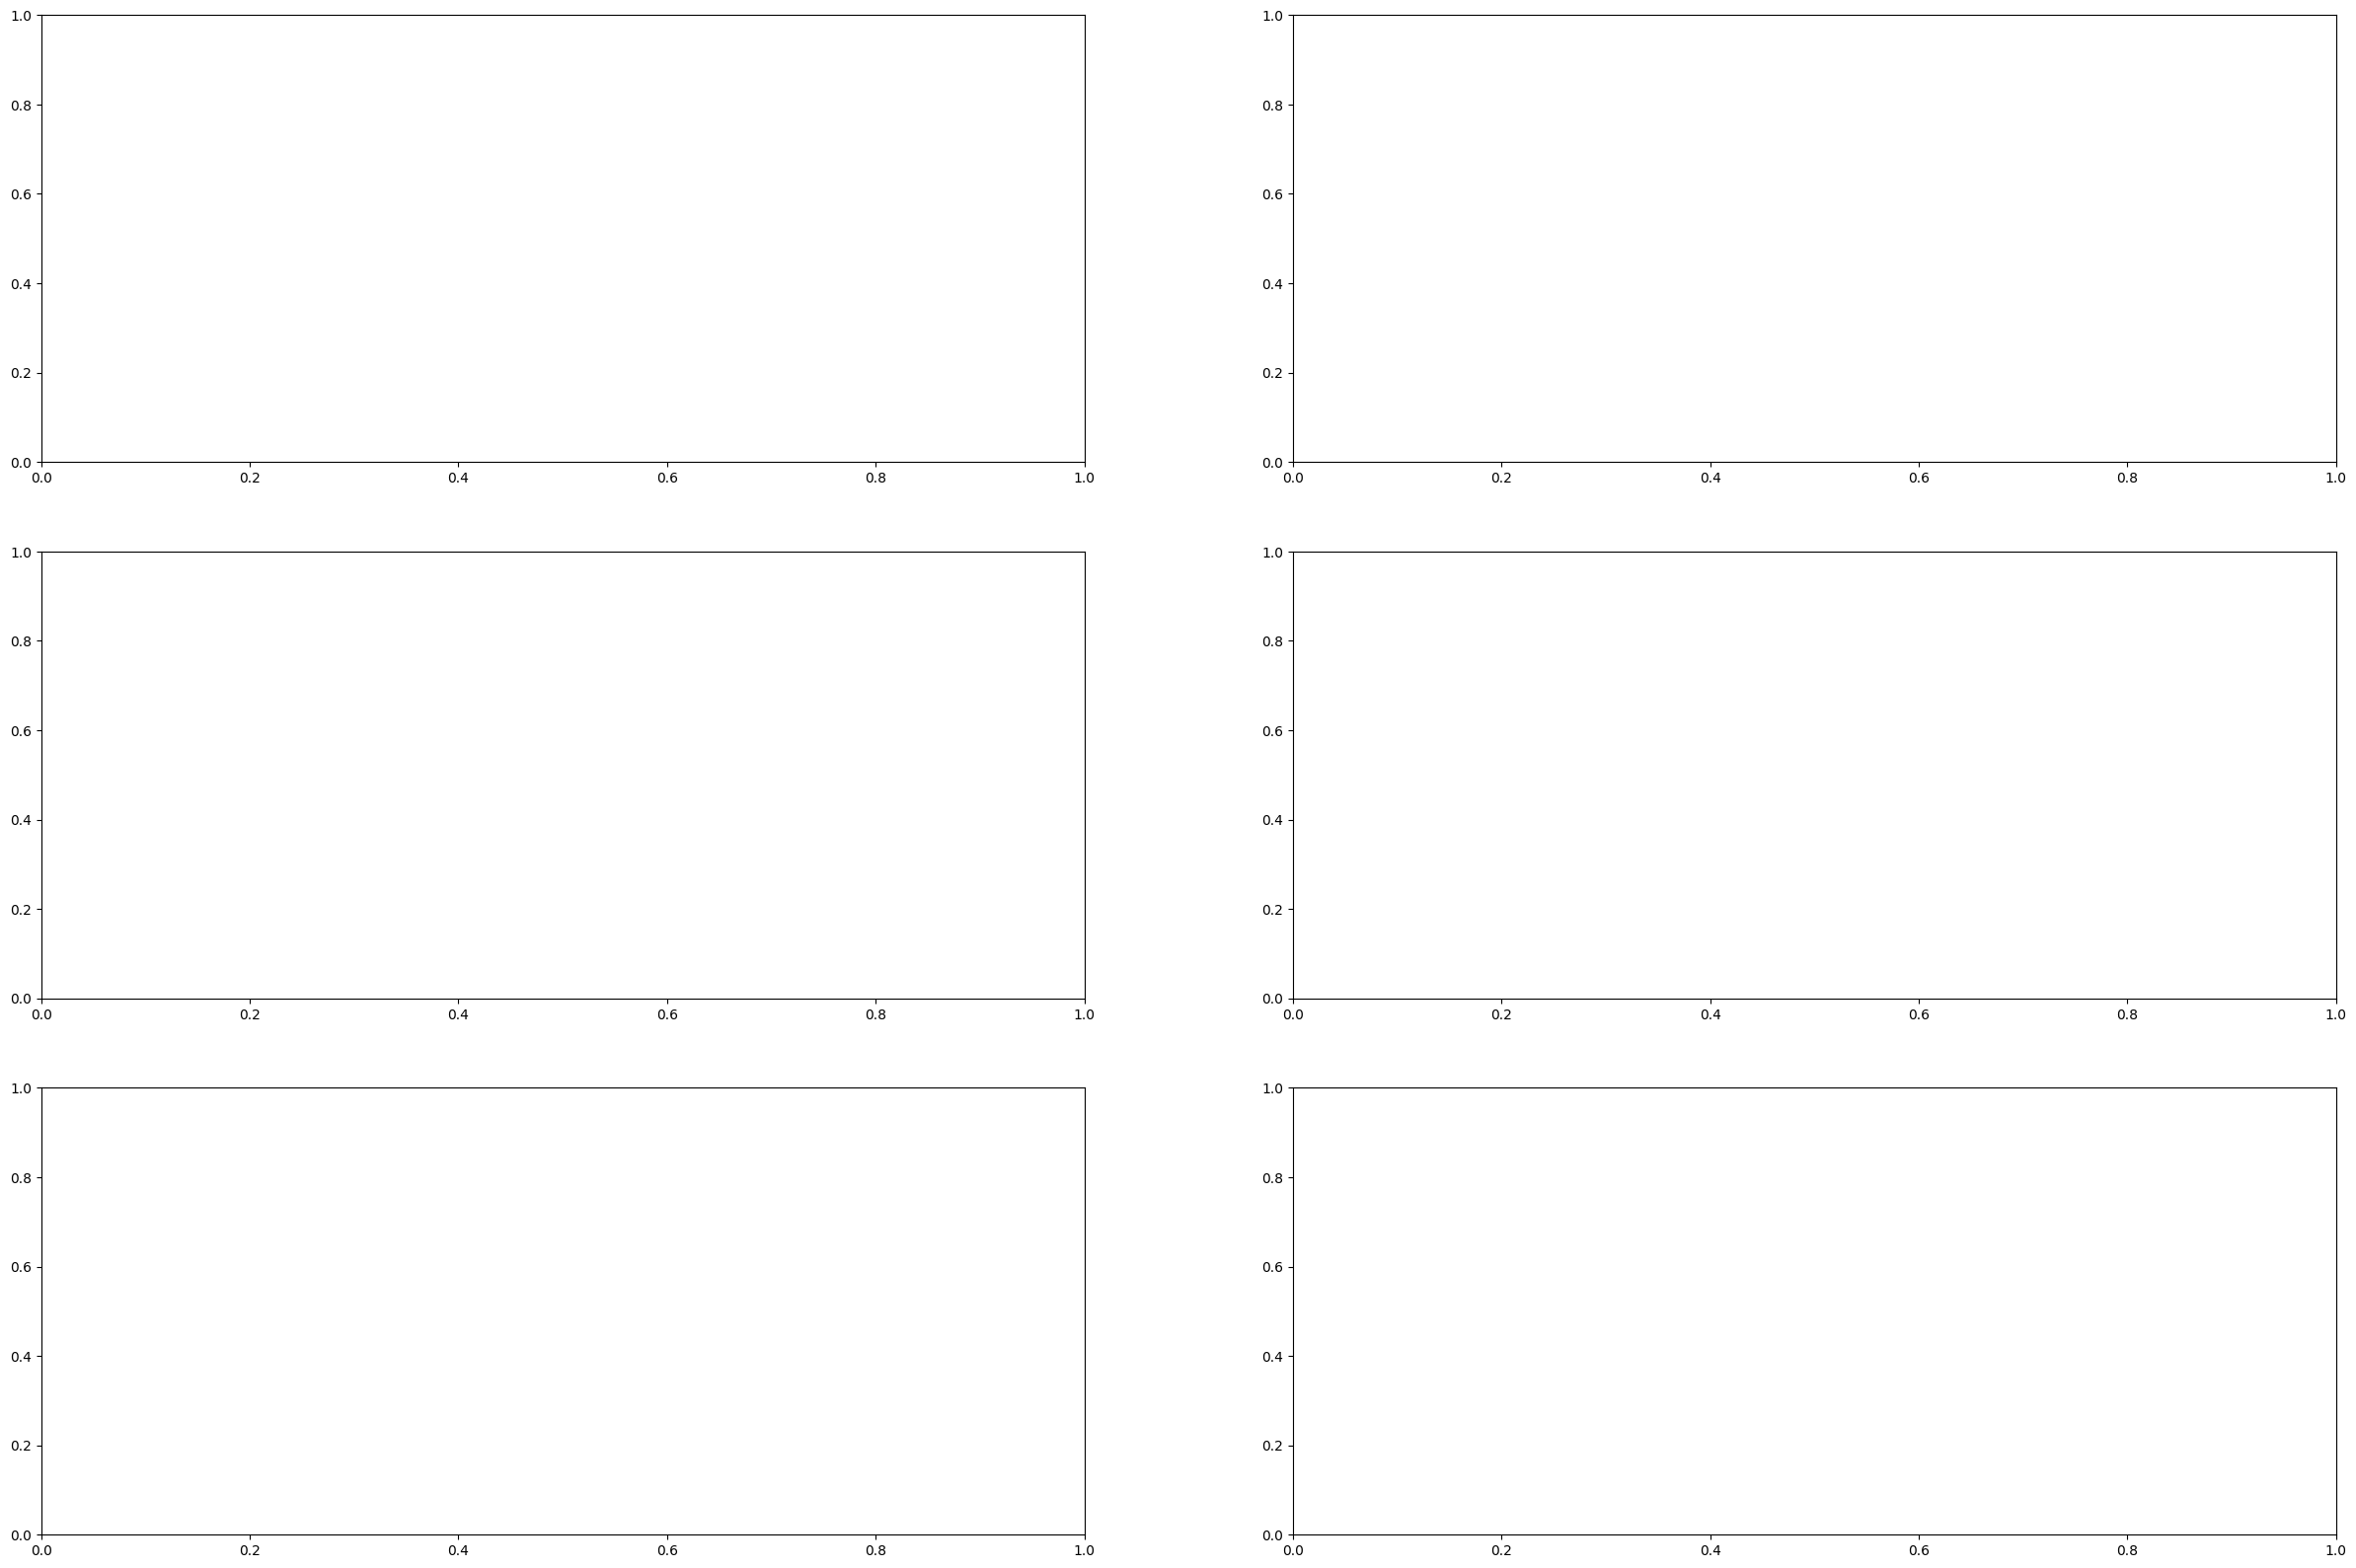

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(30, 20))
axes = axes.flatten()

for i, (qb_data, qb_name) in enumerate(qbs):
    conteo = qb_data['offense_formation'].value_counts()
    axes[i].bar(conteo.index.astype(str), conteo.values, edgecolor='black')
    axes[i].set_title(qb_name)

Podemos ver las jugadas favoritas por QB, o al menos las que mas le funcionaba, podemos hacer igual un grafico que enseñe a sus mejores receptores

In [ ]:
#Revisar Funcion, 
def tabla_targets(df_qb, qb_name, min_targets=10, top=None):
    vc = df_qb['receiver'].value_counts()
    total = int(vc.sum())
    tabla = (vc.rename('targets').to_frame()
               .assign(pct=lambda t: (t['targets']/total).round(4))
               .assign(pct_acum=lambda t: t['pct'].cumsum().round(4)))
    if min_targets:
        tabla = tabla[tabla['targets'] >= min_targets]
    if top:
        tabla = tabla.head(top)
    tabla.index.name = f'{qb_name} – receiver'
    return tabla
    
tablas = {name: tabla_targets(df, name, min_targets=10) for df, name in qbs}
tabla_multi = pd.concat(tablas)  # índice: (QB, receiver)
tabla_multi.head(3)

In [32]:
tabla_multi.to_csv("targets_por_qb.csv", encoding="utf-8")

NameError: name 'tabla_multi' is not defined

### Targets
* Es el número total de pases lanzados hacia un receptor específico (también llamado targets en NFL).
### Pct (Porcentaje)
* Es el porcentaje de targets de ese receptor respecto al total de pases de ese QB.
### Pct acum (Porcentaje acumulado)
* Es el acumulado de pct conforme bajas en la lista de receptores.

In [33]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [34]:
import seaborn as sns
print(pass_play.columns)
qb_boxplot = sns.boxplot(data=pass_play, x="air_yards", y="yards_after_catch");
qb_boxplot.set(
xlabel="Pass length (long >= 20 yards, short < 20 yards)")
plt.show

NameError: name 'pass_play' is not defined

Aqui podemos ver que los diagramas de caja estan muy juntoss, lo que podemos hacer es separarlos para ver su distribucion

In [ ]:
df = pass_play.copy()

bins   = [-10, 0, 10, 20, 40, 100]
labels = ['Behind LOS', '0–9', '10–19', '20–39', '40+']
df['air_bin'] = pd.cut(df['air_yards'], bins=bins, labels=labels, right=False)

ax = sns.boxplot(data=df, x='air_bin', y='yards_after_catch', showfliers=False)
ax.set(
    xlabel='Air Yards (binned)', 
    ylabel='Yards After Catch'
)
plt.tight_layout()
plt.show()

Aqui podemos ver como se concentran los datos, y tambien que cuando hay perdida de yaras por aire, tienen mas ganancia de yardas despues de atrapar el balon, siendo esto porque son jugadas que pasan a los laterales ya que no tienen algun receptor libre

Ahora volveremos a extraer columnas de nuestro dataset original, esto para poder darle un enfoque mas enfocado en la ofensiva, tambien teniendo el objetivo que nos ayude a apostar

In [35]:
cols = [
    'season','season_type','week','time_of_day','stadium','weather',
    'div_game','surface','home_coach','away_coach','drive','play','play_type','play_deleted',
    'touchdown','rush_touchdown','pass_touchdown','return_touchdown',
    'field_goal_attempt','field_goal_result','extra_point_attempt',
    'extra_point_result','extra_point_prob','two_point_attempt',
    'two_point_conv_result','two_point_conversion_prob',
    'safety','safety_prob','interception','fumble','sack',
    'out_of_bounds','touchback','aborted_play','no_huddle',
    'special_teams_play','offense_formation',
    'passer','pass','pass_length','pass_location',
    'receiver','yards_after_catch','route','time_to_throw',
    'qb_dropback','qb_kneel','qb_spike','qb_scramble',
    'air_yards','incomplete_pass','complete_pass','passing_yards','home_team','away_team','posteam'
]
OfensiveData = data[cols]
OfensiveData

KeyError: "['offense_formation', 'route', 'time_to_throw'] not in index"

In [36]:
OfensiveData['time_to_throw'].unique()

NameError: name 'OfensiveData' is not defined

* grass / grass → césped natural (nota: el segundo trae espacio al final).

* fieldturf → césped artificial marca FieldTurf (infill de caucho/arena).

* a_turf → césped artificial marca A-Turf.

* matrixturf → césped artificial marca Matrix Turf (de Hellas, ej. AT&T Stadium).

* astroplay → césped artificial marca AstroPlay (vieja generación, infilled).

* sportturf → césped artificial marca Sporturf.

* astroturf → césped artificial marca AstroTurf (las primeras/antiguas versiones eran tipo “carpeta”, hoy hay versiones infilled).

* '' (cadena vacía) → desconocido/na.

Vamos a limpiar los datos, convertir si es necesario y llenar espacios vacios

In [37]:
import numpy as np
import pandas as pd

df = OfensiveData.copy()

# -------------------------
# 1) Quitamos espacios en blanco al inicio y al final de cada texto
# -------------------------
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.strip().replace({"None": np.nan, "none": np.nan, "NaN": np.nan, "nan": np.nan})

# -------------------------
# 2) Convertimos columnas binarias
# -------------------------
bin_cols = ['play','play_deleted','touchdown','rush_touchdown','pass_touchdown','return_touchdown',
            'field_goal_attempt','extra_point_attempt','two_point_attempt','safety','interception','fumble',
            'sack','out_of_bounds','touchback','aborted_play','no_huddle','special_teams_play','pass',
            'qb_dropback','qb_kneel','qb_spike','qb_scramble','incomplete_pass','complete_pass']

missing_bin = [c for c in bin_cols if c not in df.columns]
if missing_bin:
    print("Advertencia - no están estas columnas binarias:", missing_bin)

present_bin = [c for c in bin_cols if c in df.columns]
df[present_bin] = df[present_bin].apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

# -------------------------
# 3) Formateo de fechas, se convierte de texto a formato de fecha 
# -------------------------
# Cambia los nombres si los tuyos son distintos:
possible_dt = ["game_date", "game_datetime", "time_of_day"]
for c in possible_dt:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# -------------------------
# 4) Superficie y clima (normalización + categorías)
# -------------------------
if "surface" in df.columns:
    df["surface"] = df["surface"].str.lower().str.replace(r"\s+", " ", regex=True)
    surface_map = {
        "natural grass":"grass","grass":"grass","kentucky bluegrass":"grass","bermuda grass":"grass",
        "fieldturf":"turf","artificial":"turf","turf":"turf","astro turf":"turf","synthetic":"turf"
    }
    df["surface_norm"] = df["surface"].map(surface_map).fillna("other")

if "weather" in df.columns:
    w = df["weather"].str.lower()
    def bucket_weather(x):
        if pd.isna(x): return "unknown"
        if any(k in x for k in ["rain","showers","drizzle"]): return "rain"
        if any(k in x for k in ["snow","flurries","sleet"]): return "snow"
        if any(k in x for k in ["wind","breez"]): return "wind"
        if any(k in x for k in ["sun","clear","fair"]): return "clear"
        if any(k in x for k in ["cloud","overcast","fog","mist"]): return "cloudy"
        return "other"
    df["weather_bucket"] = w.apply(bucket_weather)

# -------------------------
# 5) Campos de pase: categorías limpias
# -------------------------
for c in ["offense_formation","pass_length","pass_location","route"]:
    if c in df.columns:
        df[c] = df[c].str.lower().replace({"": np.nan})

# Top-N categorías para 'route' (evita demasiadas dummies)
if "route" in df.columns:
    topN = 10
    top_routes = df["route"].value_counts().head(topN).index
    df["route_top"] = np.where(df["route"].isin(top_routes), df["route"], "other_or_nan")

# -------------------------
# 6) Variables numéricas con posibles strings
# -------------------------
num_like = ["yards_after_catch","air_yards","offense_players"]
for c in num_like:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Imputación simple (mediana) para numéricos
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# -------------------------
# 7) Dummies de categóricas relevantes
# -------------------------
cat_to_dummify = []
for c in ["surface_norm","weather_bucket","offense_formation","pass_length","pass_location","route_top"]:
    if c in df.columns:
        cat_to_dummify.append(c)

df = pd.get_dummies(df, columns=cat_to_dummify, drop_first=True)

OfensiveData_clean = df
print("Shape final:", OfensiveData_clean.shape)


NameError: name 'OfensiveData' is not defined

In [38]:
OfensiveData_clean
print(OfensiveData_clean.isna().sum())

NameError: name 'OfensiveData_clean' is not defined

In [39]:
valores_unicos = OfensiveData_clean['receiver'].unique()

NameError: name 'OfensiveData_clean' is not defined

In [40]:
OfensiveData_clean.columns

NameError: name 'OfensiveData_clean' is not defined

In [41]:
print(nan_routes_df['play_type'].value_counts(dropna=False))

NameError: name 'nan_routes_df' is not defined

Aqui vemos que aunque route, tengamos muchos Na, vemos que mas del 62% de nuestro dataset nos enfrentamos con run, que igual haiendo la comparacion, sigue habiendo una mas abundancia de pases que de carreras en nuestro dataset.

Ahora vamos a analizar los dos siguientes qb del partido de Chiefs vs Commanders

In [45]:
pbp_py_p_s_corregido = \
    data.query("play_deleted == 0 and play_type == 'pass' and sack == 0 and incomplete_pass == 0 and interception == 0") \
    .groupby(["passer", "season", "week", "home_team", "away_team"]) \
    .agg({
        "passing_yards": ["sum", "count"],
        "air_yards": ["sum", "count"]
        
    })

In [50]:
# --- Definimos los enfrentamientos que buscamos ---
jugador_1 = "D.Maye"
oponente_1 = "FAL"

jugador_2 = "M.Penix"
oponente_2 = "NE"

# --- Corregimos el query ---
stats_enfrentamiento = pbp_py_p_s_corregido.query(
    # --- Condición 1: D.Maye contra FAL ---
    "(passer == @jugador_1 and (home_team == @oponente_1 or away_team == @oponente_1))" +
    
    " or " + # O...
    
    # --- Condición 2: M.Penix contra NE ---
    "(passer == @jugador_2 and (home_team == @oponente_2 or away_team == @oponente_2))"
)

print(stats_enfrentamiento)

Empty DataFrame
Columns: [(passing_yards, sum), (passing_yards, count), (air_yards, sum), (air_yards, count)]
Index: []


Lo cual realmente es muy cercano, ya que el registro de Mahomes en ese partido fue de 

In [77]:
lista_jugadores = ["J.McCarthy"]  
equipo_rival = "DET"

stats_mariota_vs_kc = pbp_py_p_s_corregido.query(
    "passer in @lista_jugadores and " +
    "(home_team == @equipo_rival or away_team == @equipo_rival)"
)

print(stats_mariota_vs_kc)

Empty DataFrame
Columns: [(passing_yards, sum), (passing_yards, count), (air_yards, sum), (air_yards, count)]
Index: []


In [58]:
print(OfensiveData_clean.incomplete_pass)

NameError: name 'OfensiveData_clean' is not defined

In [59]:
!pip install scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [62]:
print("Paso 1: Creando estadísticas defensivas por juego...")
# Usamos play_type == 'pass' para incluir sacks en las yardas permitidas
pbp_pass_plays = data.query("play_deleted == 0 and play_type == 'pass'")

# Creamos la columna 'defteam' (el equipo defensivo)
pbp_pass_plays['defteam'] = np.where(
    pbp_pass_plays['posteam'] == pbp_pass_plays['home_team'], 
    pbp_pass_plays['away_team'], 
    pbp_pass_plays['home_team']
)

# Agrupamos por juego para CADA DEFENSA
df_def_stats = pbp_pass_plays.groupby(
    ['defteam', 'season', 'week']
).agg(
    yards_allowed_game=('passing_yards', 'sum'),
    tds_allowed_game=('pass_touchdown', 'sum'),
    ints_made_game=('interception', 'sum') 
).reset_index()


# --- PASO 2: CREAR STATS OFENSIVAS (POR JUEGO) ---
print("Paso 2: Creando estadísticas ofensivas por juego...")
# Filtramos solo por INTENTOS de pase (sin sacks), como descubrimos
pbp_pass_attempts = OfensiveData_clean.query(
    "play_deleted == 0 and play_type == 'pass' and sack == 0"
)

# Agrupamos por juego para CADA PASADOR
df_agg_offense = pbp_pass_attempts.groupby(
    ['passer', 'posteam', 'season', 'week', 'home_team', 'away_team']
).agg(
    passing_yards_game=('passing_yards', 'sum'),
    pass_attempts_game=('play_type', 'count')
).reset_index()

# Añadimos el oponente y si es local
df_agg_offense['X_opponent'] = np.where(
    df_agg_offense['posteam'] == df_agg_offense['home_team'],
    df_agg_offense['away_team'],
    df_agg_offense['home_team']
)
df_agg_offense['X_is_home'] = np.where(
    df_agg_offense['posteam'] == df_agg_offense['home_team'], 1, 0
)


# --- PASO 3: CREAR INFO DEL JUEGO (CLIMA Y SUPERFICIE LIMPIOS) ---
print("Paso 3: Creando y limpiando info del juego (clima, superficie)...")
df_game_info = OfensiveData_clean.groupby(
    ['season', 'week', 'home_team', 'away_team']
).agg(
    surface_raw=('surface', 'first'),
    weather_raw=('weather', 'first')
).reset_index()

# Limpieza de Superficie (tu mapa original)
surface_map = {
    "natural grass":"grass","grass":"grass","kentucky bluegrass":"grass","bermuda grass":"grass",
    "fieldturf":"turf","artificial":"turf","turf":"turf","astro turf":"turf","synthetic":"turf"
}
df_game_info["surface_norm"] = df_game_info["surface_raw"].str.lower().map(surface_map).fillna("other")

# Limpieza de Clima (tu función original)
def bucket_weather(x):
    if pd.isna(x): return "unknown"
    x = str(x).lower()
    if any(k in x for k in ["dome","indoor"]): return "dome" # Revisar domo primero
    if any(k in x for k in ["rain","showers","drizzle"]): return "rain"
    if any(k in x for k in ["snow","flurries","sleet"]): return "snow"
    if any(k in x for k in ["wind","breez"]): return "wind"
    if any(k in x for k in ["sun","clear","fair"]): return "clear"
    if any(k in x for k in ["cloud","overcast","fog","mist"]): return "cloudy"
    return "other"

df_game_info["weather_bucket"] = df_game_info["weather_raw"].apply(bucket_weather)


# --- PASO 4: UNIR TODO EN UN DATAFRAME MAESTRO ---
print("Paso 4: Uniendo todos los DataFrames...")
# Merge Ofensiva + Defensa
df_master = pd.merge(
    df_agg_offense,
    df_def_stats,
    left_on=['X_opponent', 'season', 'week'],
    right_on=['defteam', 'season', 'week'],
    how='left'
)

# Merge (Of+Def) + Game Info (limpio)
df_master_final = pd.merge(
    df_master,
    df_game_info.drop(columns=['surface_raw', 'weather_raw']), # Quitamos las 'raw'
    on=['season', 'week', 'home_team', 'away_team'],
    how='left'
)


# --- PASO 5: INGENIERÍA DE FEATURES (PROMEDIOS MÓVILES) ---
print("Paso 5: Creando features de promedios móviles...")

# --- 1. Features Ofensivas (por pasador) ---
df_master_final = df_master_final.sort_values(by=['passer', 'season', 'week'])
g_passer = df_master_final.groupby(['passer', 'season']) # Agrupamos por temporada

# .shift(1) para usar solo datos pasados
# Rolling = Forma Reciente
df_master_final['X_passer_avg_yards_L3'] = g_passer['passing_yards_game'].shift(1).rolling(3, min_periods=1).mean()
# Expanding = Calidad de la Temporada
df_master_final['X_passer_avg_yards_Season'] = g_passer['passing_yards_game'].shift(1).expanding(min_periods=1).mean()


# --- 2. Features Defensivas (por oponente) ---
df_master_final = df_master_final.sort_values(by=['defteam', 'season', 'week'])
g_defteam = df_master_final.groupby(['defteam', 'season']) # Agrupamos por temporada

# Rolling = Forma Reciente
df_master_final['X_def_avg_yards_allowed_L3'] = g_defteam['yards_allowed_game'].shift(1).rolling(3, min_periods=1).mean()
# Expanding = Calidad de la Temporada
df_master_final['X_def_avg_yards_allowed_Season'] = g_defteam['yards_allowed_game'].shift(1).expanding(min_periods=1).mean()


# --- ¡NUEVO PASO 5.5: CREAR FEATURES DE ENFRENTAMIENTO! ---
print("Paso 5.5: Creando features de 'mismatch' (enfrentamiento)...")

# Esta feature mide la "calidad real" del QB vs. la "calidad real" de la defensa
df_master_final['X_pass_vs_def_Season'] = \
    df_master_final['X_passer_avg_yards_Season'] - df_master_final['X_def_avg_yards_allowed_Season']

# Esta feature mide la "forma reciente" del QB vs. la "forma reciente" de la defensa
df_master_final['X_pass_vs_def_L3'] = \
    df_master_final['X_passer_avg_yards_L3'] - df_master_final['X_def_avg_yards_allowed_L3']

# --- PASO 6 (MODIFICADO): PREPARAR DATOS PARA EL MODELO (Versión 5) ---
print("Paso 6 (Versión 5): Forzando al modelo a usar SOLO features de 'enfrentamiento'...")

# Lista final de features que usaremos
features = [
    # --- PROMEDIOS CRUDOS ELIMINADOS ---
    # 'X_passer_avg_yards_L3',
    # 'X_passer_avg_yards_Season',
    # 'X_def_avg_yards_allowed_L3',
    # 'X_def_avg_yards_allowed_Season',
    
    # --- SOLO MANTENEMOS LAS FEATURES DE 'MISMATCH' ---
    'X_pass_vs_def_Season', # Calidad de temporada del QB vs. Defensa
    'X_pass_vs_def_L3',     # Forma reciente del QB vs. Defensa
    
    # --- MANTENEMOS EL CONTEXTO ---
    'X_is_home',
    'week',
    'X_opponent',
    'surface_norm',
    'weather_bucket'
]
target = 'passing_yards_game'

# 1. Limpiamos NaNs (igual que antes)
df_model = df_master_final.dropna(subset=features)

# 2. Filtramos por datos recientes (¡MANTENEMOS ESTO, FUE UNA BUENA IDEA!)
df_model_reciente = df_model[df_model['season'] >= 2021]

# 3. Convertimos categóricas en números
X = pd.get_dummies(
    df_model_reciente[features], 
    columns=['X_opponent', 'surface_norm', 'weather_bucket'],
    drop_first=True
)
y = df_model_reciente[target]

# 4. Dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Nuevos datos de entrenamiento: {X_train.shape}")
print(f"Nuevos datos de prueba: {X_test.shape}")


# --- PASO 7 (MODIFICADO): ENTRENAR Y EVALUAR (Versión 5) ---
print("\n--- PASO 7: ENTRENANDO EL RANDOM FOREST (Versión 5) ---")

rf_model_v5 = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42, 
    n_jobs=-1
)

rf_model_v5.fit(X_train, y_train)
print("¡Modelo entrenado!")

# Evaluar el modelo
predictions = rf_model_v5.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print("\n--- RESULTADOS DEL MODELO (Versión 5) ---")
print(f"Error Absoluto Medio (MAE): {mae:.2f} yardas")

# Ver qué features fueron más importantes
importances = pd.Series(
    rf_model_v5.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

print("\n--- IMPORTANCIA DE LAS FEATURES (Versión 5) ---")
print(importances.head(15))

# --- PASO 7: ENTRENAR Y EVALUAR (Versión 4) ---
print("\n--- PASO 7: ENTRENANDO EL RANDOM FOREST (Versión 4) ---")

rf_model_v4 = RandomForestRegressor(
    n_estimators=100, 
    max_depth=5, 
    random_state=42, 
    n_jobs=-1
)

rf_model_v4.fit(X_train, y_train)
print("¡Modelo entrenado!")

# Evaluar el modelo
predictions = rf_model_v4.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print("\n--- RESULTADOS DEL MODELO (Versión 4) ---")
print(f"Error Absoluto Medio (MAE): {mae:.2f} yardas")

# Ver qué features fueron más importantes
importances = pd.Series(
    rf_model_v4.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

print("\n--- IMPORTANCIA DE LAS FEATURES (Versión 4) ---")
print(importances.head(15))
# Evaluar el modelo
predictions = rf_model_v4.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print("\n--- RESULTADOS DEL MODELO (Versión 4) ---")
print(f"Error Absoluto Medio (MAE): {mae:.2f} yardas")

# Ver qué features fueron más importantes
importances = pd.Series(
    rf_model_v4.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

print("\n--- IMPORTANCIA DE LAS FEATURES (Versión 4) ---")
print(importances.head(15))

Paso 1: Creando estadísticas defensivas por juego...
Paso 2: Creando estadísticas ofensivas por juego...


NameError: name 'OfensiveData_clean' is not defined

In [61]:
# --- 1. Definir los datos del partido de HOY ---
# (Jueves por la Noche, Semana 9, 2025, BAL @ MIA)
# (Superficie: Hard Rock Stadium es 'grass')
# (Clima: Parcialmente nublado, sin lluvia -> 'cloudy')

partido_info = {
    'season': 2025,
    'week': 9,  # Es el primer partido de la Semana 9
    'X_opponent_Lamar': 'MIA',
    'X_opponent_Tua': 'BAL',
    'surface_norm': 'grass',       # Hard Rock Stadium es Bermuda grass
    'weather_bucket': 'cloudy'     # Pronóstico de esta noche es "clear" / "partly cloudy"
}

# --- 2. Encontrar los últimos promedios de tu DataFrame ---
# (Usamos .iloc[-1] para tomar la última fila/último juego registrado, que sería de la Semana 8)

# Filtramos por temporada 2025 para obtener la data más reciente
df_2025 = df_master_final[df_master_final['season'] == 2025]

# --- Stats de Lamar Jackson (Ofensiva) ---
# ¡¡ASEGÚRATE de que el nombre 'L.Jackson' coincida con tu DataFrame!!
stats_lamar = df_2025[
    df_2025['passer'] == 'L.Jackson'
].sort_values(by='week').iloc[-1]

# --- Stats de Tua Tagovailoa (Ofensiva) ---
# ¡¡ASEGÚRATE de que el nombre 'T.Tagovailoa' coincida con tu DataFrame!!
stats_tua = df_2025[
    df_2025['passer'] == 'T.Tagovailoa'
].sort_values(by='week').iloc[-1]

# --- Stats de la Defensa de MIA ---
stats_def_mia = df_2025[
    df_2025['defteam'] == 'MIA'
].sort_values(by='week').iloc[-1]

# --- Stats de la Defensa de BAL ---
stats_def_bal = df_2025[
    df_2025['defteam'] == 'BAL'
].sort_values(by='week').iloc[-1]


# --- 3. Construir la fila de predicción para Lamar Jackson ---
pred_lamar = {
    # --- Features de Enfrentamiento (las más importantes) ---
    'X_pass_vs_def_Season': stats_lamar['X_passer_avg_yards_Season'] - stats_def_mia['X_def_avg_yards_allowed_Season'],
    'X_pass_vs_def_L3': stats_lamar['X_passer_avg_yards_L3'] - stats_def_mia['X_def_avg_yards_allowed_L3'],

    # --- Features de Contexto ---
    'X_is_home': 0, # Lamar (BAL) es visitante
    'week': partido_info['week'],
    
    # --- Features Categóricas (para dummies) ---
    'X_opponent': partido_info['X_opponent_Lamar'],
    'surface_norm': partido_info['surface_norm'],
    'weather_bucket': partido_info['weather_bucket']
}


# --- 4. Construir la fila de predicción para Tua Tagovailoa ---
pred_tua = {
    # --- Features de Enfrentamiento ---
    'X_pass_vs_def_Season': stats_tua['X_passer_avg_yards_Season'] - stats_def_bal['X_def_avg_yards_allowed_Season'],
    'X_pass_vs_def_L3': stats_tua['X_passer_avg_yards_L3'] - stats_def_bal['X_def_avg_yards_allowed_L3'],

    # --- Features de Contexto ---
    'X_is_home': 1, # Tua (MIA) juega en casa
    'week': partido_info['week'],

    # --- Features Categóricas (para dummies) ---
    'X_opponent': partido_info['X_opponent_Tua'],
    'surface_norm': partido_info['surface_norm'],
    'weather_bucket': partido_info['weather_bucket']
}

NameError: name 'df_master_final' is not defined

In [54]:
# 1. Crear un DataFrame con nuestras dos filas de predicción
# ¡MODIFICADO! Usamos las variables de Lamar y Tua
df_prediccion = pd.DataFrame([pred_lamar, pred_tua])

# 2. Convertir categóricas en Dummies
df_prediccion_dummies = pd.get_dummies(
    df_prediccion, 
    columns=['X_opponent', 'surface_norm', 'weather_bucket']
)

# 3. ¡¡CRUCIAL!! Alinear las columnas con el modelo entrenado
# (Asumimos que X_train es el de tu "Versión 5")
# Esto añade columnas faltantes (ej. 'X_opponent_WAS') con '0' 
# y elimina columnas que el modelo no conoce.
X_pred, _ = df_prediccion_dummies.align(X_train, join='right', axis=1, fill_value=0)

# 4. Seleccionar las features finales en el orden correcto
X_pred_final = X_pred[X_train.columns]

# --- 5. ¡¡HACER LA PREDICCIÓN!! ---
# (Asumimos que rf_model_v5 es tu modelo entrenado)
predicciones_finales = rf_model_v5.predict(X_pred_final)


# --- 6. IMPRIMIR RESULTADOS (MODIFICADO) ---
print("\n--- PREDICCIONES PARA LA SEMANA 9 (BAL @ MIA) ---")
# Líneas de apuestas encontradas para el 30 de octubre de 2025:
print(f"(Línea de apuesta de L.Jackson: 234.5 yardas)")
print(f"(Línea de apuesta de T.Tagovailoa: 217.5 yardas)")
print("-" * 45)
print(f"Predicción del Modelo para L.Jackson: {predicciones_finales[0]:.2f} yardas")
print(f"Predicción del Modelo para T.Tagovailoa: {predicciones_finales[1]:.2f} yardas")


--- PREDICCIONES PARA LA SEMANA 9 (BAL @ MIA) ---
(Línea de apuesta de L.Jackson: 234.5 yardas)
(Línea de apuesta de T.Tagovailoa: 217.5 yardas)
---------------------------------------------
Predicción del Modelo para L.Jackson: 323.71 yardas
Predicción del Modelo para T.Tagovailoa: 330.38 yardas


Calculando MAE para diferentes valores de 'max_depth'...
Profundidad | Error (Test) | Error (Train)
---------------------------------------
 3          | 92.02        | 86.78       
 5          | 91.96        | 82.70       
 7          | 92.06        | 77.48       
 8          | 92.07        | 74.82       
 10         | 92.44        | 69.86       
 12         | 92.84        | 65.90       
 15         | 93.02        | 61.78       
 20         | 93.20        | 59.17       
 25         | 93.24        | 58.84       
 None       | 93.24        | 58.83       

Gráfico 'max_depth_validation_curve.png' guardado.
El mejor MAE de prueba fue: 91.96 yardas


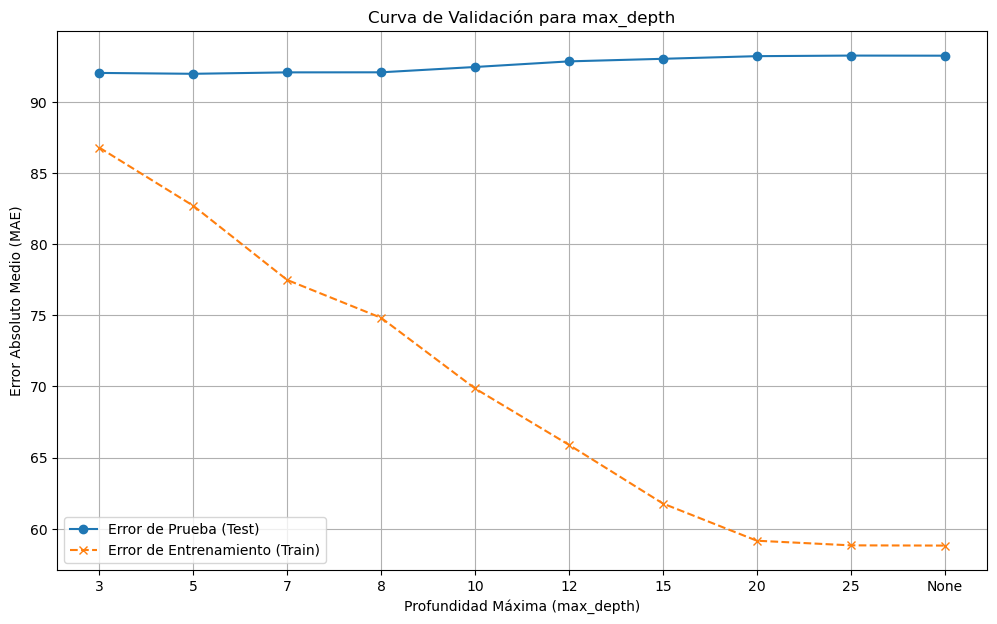

In [57]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# --- Asumimos que X_train, y_train, X_test, y_test ya existen ---
# --- (Deben ser los de la "Versión 5" que probamos) ---

# 1. Definimos los valores de max_depth que queremos probar
# 'None' significa profundidad ilimitada (para ver el overfitting)
depth_values = [3, 5, 7, 8, 10, 12, 15, 20, 25, None] 
mae_scores = []
mae_train_scores = [] # ¡Extra! Para ver el overfitting

print("Calculando MAE para diferentes valores de 'max_depth'...")
print("Profundidad | Error (Test) | Error (Train)")
print("---------------------------------------")

for depth in depth_values:
    
    # Definimos el modelo
    model = RandomForestRegressor(
        n_estimators=100,      # Usamos un número fijo de árboles
        max_depth=depth,       # <-- ¡Esto es lo que cambiamos!
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=5     # Usamos un 'leaf' razonable para estabilizar
    )
    
    # 2. Entrenar el modelo
    model.fit(X_train, y_train)
    
    # 3. Evaluar en datos de PRUEBA (Test)
    preds_test = model.predict(X_test)
    mae_test = mean_absolute_error(y_test, preds_test)
    mae_scores.append(mae_test)
    
    # 4. Evaluar en datos de ENTRENAMIENTO (Train)
    preds_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, preds_train)
    mae_train_scores.append(mae_train)
    
    print(f" {str(depth):<10} | {mae_test:<12.2f} | {mae_train:<12.2f}")

# --- 5. Graficar los resultados ---
plt.figure(figsize=(12, 7))
plt.plot(range(len(depth_values)), mae_scores, marker='o', label='Error de Prueba (Test)')
plt.plot(range(len(depth_values)), mae_train_scores, marker='x', linestyle='--', label='Error de Entrenamiento (Train)')
plt.title('Curva de Validación para max_depth')
plt.xlabel('Profundidad Máxima (max_depth)')
plt.ylabel('Error Absoluto Medio (MAE)')
plt.xticks(range(len(depth_values)), labels=[str(d) for d in depth_values]) # Pone los nombres en el eje X
plt.legend()
plt.grid(True)
plt.savefig('max_depth_validation_curve.png')

print("\nGráfico 'max_depth_validation_curve.png' guardado.")
print(f"El mejor MAE de prueba fue: {min(mae_scores):.2f} yardas")

In [76]:
# 1. Definir las columnas que queremos conservar
columnas_deseadas = [
    # Contexto Partido
    'game_id', 'play_id', 'season', 'week', 'season_type',
    'home_team', 'away_team', 'posteam', 'defteam',
    'roof', 'surface', 'temp', 'wind',
    
    # Contexto Jugada
    'qtr', 'down', 'ydstogo', 'yardline_100', 'goal_to_go',
    'game_seconds_remaining', 'score_differential', 'play_type',
    'shotgun', 'no_huddle',
    
    # Jugadores y Stats Básicas
    'passer_player_name', 'rusher_player_name', 'receiver_player_name',
    'yards_gained', 'passing_yards', 'rushing_yards',
    'complete_pass', 'incomplete_pass', 'air_yards', 'yards_after_catch',
    'touchdown', 'pass_touchdown', 'rush_touchdown',
    'interception', 'sack', 'fumble_lost',
    
    # Analytics
    'epa', 'qb_epa', 'wpa', 'cpoe', 'xpass'
]

# 2. Definir las jugadas que queremos
tipos_de_jugada_ofensiva = ['pass', 'run']

# 3. Filtrar las filas
# (Asegúrate de que 'data' sea tu DataFrame de Polars)

# .to_pandas() es necesario si 'data' es un DataFrame de Polars
if not hasattr(data, 'iloc'): 
    data_pd = data.to_pandas()
else:
    data_pd = data

df_filtrado = data_pd[
    (data_pd['play_type'].isin(tipos_de_jugada_ofensiva)) &
    (data_pd['play_deleted'] == 0)
]

# 4. Seleccionar solo las columnas deseadas
# Usamos .reindex para evitar errores si falta alguna columna
columnas_finales = [col for col in columnas_deseadas if col in df_filtrado.columns]
OfensivaClean = df_filtrado[columnas_finales].copy()

# 5. Guardar (Opcional)
OfensivaClean.to_csv('OfensivaClean.csv', index=False)

print(f"¡Dataset OfensivaClean creado!")
print(f"Columnas originales: {len(data.columns)}")
print(f"Columnas nuevas: {len(OfensivaClean.columns)}")
print(f"Forma del nuevo dataset: {OfensivaClean.shape}")

¡Dataset OfensivaClean creado!
Columnas originales: 372
Columnas nuevas: 44
Forma del nuevo dataset: (290991, 44)


In [79]:
pip install scikit-learn

  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   -------- ------------------------------- 1.8/8.9 MB 14.4 MB/s eta 0:00:01
   -------------- ------------------------- 3.1/8.9 MB 11.5 MB/s eta 0:00:01
   ---------------------------- ----------- 6.3/8.9 MB 11.7 MB/s eta 0:00:01
   ------------------------------------ --- 8.1/8.9 MB 10.9 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 10.8 MB/s  0:00:00
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ---------------------------------------- 0.0/41.3 MB ? eta -:--:--
   - -------------------------------------- 1.8/41.3 MB 9.1 MB/s eta 0:00:05
   --- ------------------------------------ 3.9/41.3 MB 9.4 MB/s eta 0:00:04
   ----- ---------------------------------- 5.8/41.3 MB 9.5 MB/s eta 0:00:04
   ------- -------------------------------- 7.9/41.3 MB 9.5 MB/s

In [63]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings

# Ignorar advertencias para que la salida sea más limpia
warnings.filterwarnings('ignore')

# --- PASO 1: LEER TU NUEVO CSV LIMPIO ---
print("Paso 1: Leyendo 'OfensivaClean.csv'...")
try:
    df_clean = pd.read_csv('OfensivaClean.csv')
except FileNotFoundError:
    print("¡ERROR! No se encontró el archivo 'OfensivaClean.csv'.")
    print("Asegúrate de que esté en la misma carpeta que este script.")
    exit()
except Exception as e:
    print(f"Error al leer el CSV: {e}")
    exit()

# --- PASO 2: AGREGAR STATS OFENSIVAS (EPA/CPOE) POR JUEGO ---
print("Paso 2: Agregando estadísticas ofensivas (EPA/CPOE)...")
pbp_pass_plays = df_clean.query("play_type == 'pass' and sack == 0")

df_agg_offense_v6 = pbp_pass_plays.groupby(
    ['passer_player_name', 'posteam', 'season', 'week', 'home_team', 'away_team']
).agg(
    passing_yards_game=('passing_yards', 'sum'),
    passer_epa_mean=('qb_epa', 'mean'),
    passer_cpoe_mean=('cpoe', 'mean')
).reset_index()

df_agg_offense_v6 = df_agg_offense_v6.rename(columns={'passer_player_name': 'passer'})

df_agg_offense_v6['X_opponent'] = np.where(
    df_agg_offense_v6['posteam'] == df_agg_offense_v6['home_team'],
    df_agg_offense_v6['away_team'],
    df_agg_offense_v6['home_team']
)
df_agg_offense_v6['X_is_home'] = np.where(
    df_agg_offense_v6['posteam'] == df_agg_offense_v6['home_team'], 1, 0
)

# --- PASO 3: AGREGAR STATS DEFENSIVAS (EPA PERMITIDO) POR JUEGO ---
print("Paso 3: Agregando estadísticas defensivas...")
pbp_def_plays = df_clean.query("play_type == 'pass'")

df_def_stats_v6 = pbp_def_plays.groupby(
    ['defteam', 'season', 'week']
).agg(
    def_epa_allowed_mean=('epa', 'mean')
).reset_index()

# --- PASO 4 (CORREGIDO): CREAR INFO DE JUEGO (SOLO SUPERFICIE) ---
print("Paso 4: Limpiando datos de superficie...")

surface_map = {
    "natural grass":"grass","grass":"grass","kentucky bluegrass":"grass","bermuda grass":"grass",
    "fieldturf":"turf","artificial":"turf","turf":"turf","astro turf":"turf","synthetic":"turf"
}

df_game_info = df_clean.groupby(
    ['season', 'week', 'home_team', 'away_team']
).agg(
    surface_raw=('surface', 'first') # Solo leemos 'surface'
).reset_index()

df_game_info["surface_norm"] = df_game_info["surface_raw"].str.lower().map(surface_map).fillna("other")

# --- PASO 5: UNIR TODO Y CREAR FEATURES DE TEMPORADA ---
print("Paso 5: Uniendo DataFrames y creando features de temporada...")
# Merge Ofensiva + Defensa
df_master_v6 = pd.merge(
    df_agg_offense_v6,
    df_def_stats_v6,
    left_on=['X_opponent', 'season', 'week'],
    right_on=['defteam', 'season', 'week'],
    how='left'
)
# Merge (Of+Def) + Game Info (ahora sin 'weather_raw')
df_master_final_v6 = pd.merge(
    df_master_v6,
    df_game_info.drop(columns=['surface_raw']), # Solo quitamos 'surface_raw'
    on=['season', 'week', 'home_team', 'away_team'],
    how='left'
)

# --- Features Ofensivas (Lagged) ---
df_master_final_v6 = df_master_final_v6.sort_values(by=['passer', 'season', 'week'])
g_passer = df_master_final_v6.groupby(['passer', 'season'])
df_master_final_v6['X_passer_avg_epa_Season'] = g_passer['passer_epa_mean'].shift(1).expanding(min_periods=1).mean()
df_master_final_v6['X_passer_avg_cpoe_Season'] = g_passer['passer_cpoe_mean'].shift(1).expanding(min_periods=1).mean()

# --- Features Defensivas (Lagged) ---
df_master_final_v6 = df_master_final_v6.sort_values(by=['defteam', 'season', 'week'])
g_defteam = df_master_final_v6.groupby(['defteam', 'season'])
df_master_final_v6['X_def_avg_epa_allowed_Season'] = g_defteam['def_epa_allowed_mean'].shift(1).expanding(min_periods=1).mean()

# --- Feature de "Enfrentamiento" (Mismatch) ---
df_master_final_v6['X_epa_mismatch_Season'] = \
    df_master_final_v6['X_passer_avg_epa_Season'] - df_master_final_v6['X_def_avg_epa_allowed_Season']

# --- PASO 6 (CORREGIDO): ENTRENAR EL MODELO (Versión 6) ---
print("Paso 6: Entrenando el modelo V6...")

features = [
    'X_passer_avg_epa_Season',
    'X_passer_avg_cpoe_Season',
    'X_def_avg_epa_allowed_Season',
    'X_epa_mismatch_Season',
    'X_is_home',
    'week',
    'X_opponent',
    'surface_norm'
    # 'weather_bucket' fue eliminada
]
target = 'passing_yards_game'

# --- Limpiar NaNs y Filtrar por años recientes ---
df_model_v6 = df_master_final_v6.dropna(subset=features)
df_model_reciente_v6 = df_model_v6[df_model_v6['season'] >= 2021] 

# --- Crear X y y ---
X = pd.get_dummies(
    df_model_reciente_v6[features], 
    columns=['X_opponent', 'surface_norm'], # Eliminamos weather_bucket
    drop_first=True
)
y = df_model_reciente_v6[target]

# --- Dividir ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Entrenando con {X_train.shape[0]} muestras, probando con {X_test.shape[0]} muestras.")

# --- Entrenar (usando los mejores parámetros que encontramos) ---
rf_model_v6 = RandomForestRegressor(
    n_estimators=200,    
    max_depth=5,         # El 'depth' óptimo que encontraste
    min_samples_leaf=5,  
    random_state=42, 
    n_jobs=-1
)

rf_model_v6.fit(X_train, y_train)
print("¡Modelo V6 entrenado!")

# --- PASO 7: EVALUAR EL NUEVO MODELO ---
predictions = rf_model_v6.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print("\n--- RESULTADOS (Versión 6 con EPA/CPOE) ---")
print(f"Error Absoluto Medio (MAE): {mae:.2f} yardas")

# Ver qué features importaron AHORA
importances = pd.Series(
    rf_model_v6.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

print("\n--- IMPORTANCIA DE LAS FEATURES (V6) ---")
print(importances.head(15))

Paso 1: Leyendo 'OfensivaClean.csv'...
Paso 2: Agregando estadísticas ofensivas (EPA/CPOE)...
Paso 3: Agregando estadísticas defensivas...
Paso 4: Limpiando datos de superficie...
Paso 5: Uniendo DataFrames y creando features de temporada...
Paso 6: Entrenando el modelo V6...
Entrenando con 2464 muestras, probando con 617 muestras.
¡Modelo V6 entrenado!

--- RESULTADOS (Versión 6 con EPA/CPOE) ---
Error Absoluto Medio (MAE): 79.42 yardas

--- IMPORTANCIA DE LAS FEATURES (V6) ---
X_passer_avg_epa_Season         0.448523
X_passer_avg_cpoe_Season        0.330166
week                            0.067543
X_def_avg_epa_allowed_Season    0.060921
X_epa_mismatch_Season           0.048494
surface_norm_other              0.007300
X_is_home                       0.006624
surface_norm_turf               0.005069
X_opponent_DAL                  0.003861
X_opponent_TB                   0.001846
X_opponent_DET                  0.001818
X_opponent_BAL                  0.001689
X_opponent_NE           

In [78]:
# --- 1. Definir los datos del partido de HOY ---
# (Domingo, Semana 9, 2025, DET @ MIN)
# (Superficie: U.S. Bank Stadium es 'turf')

partido_info = {
    'season': 2025,
    'week': 9,
    'X_opponent_Goff': 'MIN',       # Oponente de Goff
    'X_opponent_McCarthy': 'DET',   # Oponente de McCarthy
    'surface_norm': 'turf'            # U.S. Bank Stadium es artificial
}

# --- 2. Encontrar los últimos promedios (stats hasta Semana 8) ---
# Filtramos por temporada 2025 Y que la semana sea ANTERIOR a la 9
df_2025_previo = df_master_final_v6[
    (df_master_final_v6['season'] == 2025) &
    (df_master_final_v6['week'] < partido_info['week'])
]

# --- Stats de Jared Goff (Ofensiva) ---
# ¡¡ASEGÚRATE de que 'J.Goff' sea el nombre exacto en tu columna 'passer'!!
stats_goff = df_2025_previo[
    df_2025_previo['passer'] == 'J.Goff'  # MODIFICADO
].sort_values(by='week').iloc[-1]

# --- Stats de J.J. McCarthy (Ofensiva) ---
# ¡¡ASEGÚRATE de que 'J.McCarthy' sea el nombre exacto!!
stats_mccarthy = df_2025_previo[
    df_2025_previo['passer'] == 'J.McCarthy'  # MODIFICADO
].sort_values(by='week').iloc[-1]

# --- Stats de la Defensa de MIN ---
stats_def_min = df_2025_previo[
    df_2025_previo['defteam'] == 'MIN'  # MODIFICADO
].sort_values(by='week').iloc[-1]

# --- Stats de la Defensa de DET ---
stats_def_det = df_2025_previo[
    df_2025_previo['defteam'] == 'DET'  # MODIFICADO
].sort_values(by='week').iloc[-1]


# --- 3. Construir la fila de predicción para Jared Goff ---
pred_goff = {
    # Features de Eficiencia
    'X_passer_avg_epa_Season': stats_goff['X_passer_avg_epa_Season'],
    'X_passer_avg_cpoe_Season': stats_goff['X_passer_avg_cpoe_Season'],
    'X_def_avg_epa_allowed_Season': stats_def_min['X_def_avg_epa_allowed_Season'], # Oponente: MIN
    'X_epa_mismatch_Season': stats_goff['X_passer_avg_epa_Season'] - stats_def_min['X_def_avg_epa_allowed_Season'],
    
    # Features de Contexto
    'X_is_home': 0, # Goff (DET) es visitante
    'week': partido_info['week'],
    'X_opponent': partido_info['X_opponent_Goff'],
    'surface_norm': partido_info['surface_norm']
}

# --- 4. Construir la fila de predicción para J.J. McCarthy ---
pred_mccarthy = {
    # Features de Eficiencia
    'X_passer_avg_epa_Season': stats_mccarthy['X_passer_avg_epa_Season'],
    'X_passer_avg_cpoe_Season': stats_mccarthy['X_passer_avg_cpoe_Season'],
    'X_def_avg_epa_allowed_Season': stats_def_det['X_def_avg_epa_allowed_Season'], # Oponente: DET
    'X_epa_mismatch_Season': stats_mccarthy['X_passer_avg_epa_Season'] - stats_def_det['X_def_avg_epa_allowed_Season'],
    
    # Features de Contexto
    'X_is_home': 1, # McCarthy (MIN) es local
    'week': partido_info['week'],
    'X_opponent': partido_info['X_opponent_McCarthy'],
    'surface_norm': partido_info['surface_norm']
}

# --- 5. Pre-procesar y Predecir ---
print("\nGenerando predicciones con el modelo V6 (MAE 79.42)...")
df_prediccion = pd.DataFrame([pred_goff, pred_mccarthy]) # MODIFICADO

# Convertir categóricas en Dummies
df_prediccion_dummies = pd.get_dummies(
    df_prediccion, 
    columns=['X_opponent', 'surface_norm']
)

# ¡¡CRUCIAL!! Alinear las columnas con el modelo entrenado (X_train)
X_pred, _ = df_prediccion_dummies.align(X_train, join='right', axis=1, fill_value=0)

# Asegurarse de que el orden de columnas sea idéntico
X_pred_final = X_pred[X_train.columns]

# --- ¡¡HACER LA PREDICCIÓN!! ---
predicciones_finales = rf_model_v6.predict(X_pred_final)

# --- 6. IMPRIMIR RESULTADOS ---
print("\n--- PREDICCIONES FINALES (Modelo V6) ---")
print(f"(Línea de apuesta de J.Goff: 239.5 yardas)")
print(f"(Línea de apuesta de J.McCarthy: ~195.5 yardas)") # Línea estimada
print("-" * 45)
print(f"Predicción del Modelo para J.Goff: {predicciones_finales[0]:.2f} yardas")
print(f"Predicción del Modelo para J.McCarthy: {predicciones_finales[1]:.2f} yardas")

print("\n--- RECORDATORIO ---")
print(f"El MAE (error promedio) de este modelo es ~79 yardas.")


Generando predicciones con el modelo V6 (MAE 79.42)...

--- PREDICCIONES FINALES (Modelo V6) ---
(Línea de apuesta de J.Goff: 239.5 yardas)
(Línea de apuesta de J.McCarthy: ~195.5 yardas)
---------------------------------------------
Predicción del Modelo para J.Goff: 199.11 yardas
Predicción del Modelo para J.McCarthy: 192.51 yardas

--- RECORDATORIO ---
El MAE (error promedio) de este modelo es ~79 yardas.
